In [1]:
import torch
import gpytorch
import numpy as np
import pandas as pd

from bo_functions import calc_ei_basic
from bo_functions import ExactGPModel
from bo_functions import calc_GP_outputs
from bo_functions import train_GP_model
from bo_functions import calc_ei_basic_tot

from bo_plotters import plot_hyperparams
from bo_plotters import stdev_plotter
from bo_plotters import y_plotter
from bo_plotters import ei_plotter

In [2]:
#Pull x data from CSV
exp_data_doc = "exp_data.csv"
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
# print(x)

#Set Theta_True and Noise stdev
Theta_True = np.array([1,-1])
noise_stdev = 0.1**2

In [3]:
#Pull training data from CSV
train_data_doc = "train_2_in_data.csv"
train_data = np.array(pd.read_csv(train_data_doc, header=0,sep=","))
train_T = torch.tensor(train_data[:,1:3])
train_sse = torch.tensor(train_data[:,3])

In [4]:
# initialize likelihood and model
##Assumes a homoskedastic noise model p(y | f) = f + noise
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# We will use the simplest form of GP model, exact inference
#Defines our model in terms of the class parameters in bo_functions
model = ExactGPModel(train_T, train_sse, likelihood)

In [5]:
#Training the GP Model
iterations = 700
train_GP = train_GP_model(model, likelihood, train_T, train_sse, iterations, verbose = False)
noise_list = train_GP[0]
lengthscale_list = train_GP[1]
outputscale_list = train_GP[2]

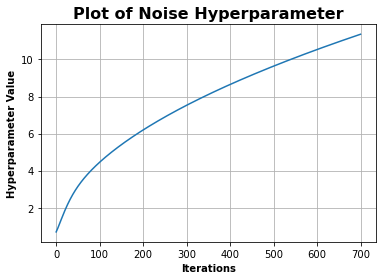

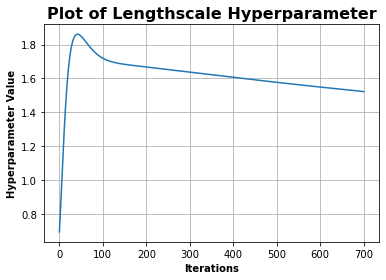

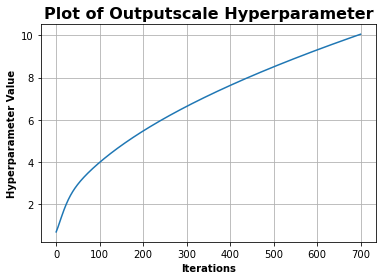

In [6]:
#Plot hyperparameters vs iteration
noise_title = "Noise Hyperparameter"
lengthscale_title = "Lengthscale Hyperparameter"
outputscale_title = "Outputscale Hyperparameter"
plot_hyperparams(iterations, noise_list,noise_title)
plot_hyperparams(iterations, lengthscale_list,lengthscale_title)
plot_hyperparams(iterations, outputscale_list,outputscale_title)

In [7]:
#Change GP Hyperparameters
# outputscale = torch.tensor([7.5325])
# lengthscale = torch.tensor([1.6364])
# noise = torch.tensor([6.6405])

outputscale = torch.tensor([1])
lengthscale = torch.tensor([1])
noise = torch.tensor([1])

model.likelihood.noise = noise
model.covar_module.base_kernel.lengthscale =lengthscale
model.covar_module.outputscale = outputscale

print("Noise Hyperparameter: ", model.likelihood.noise)
print("Lengthscale Hyperparameter: ", model.covar_module.base_kernel.lengthscale)
print("Outputscale Hyperparameter: ", model.covar_module.outputscale)

Noise Hyperparameter:  tensor([1.], grad_fn=<AddBackward0>)
Lengthscale Hyperparameter:  tensor([[1.]], grad_fn=<SoftplusBackward0>)
Outputscale Hyperparameter:  tensor(1., grad_fn=<SoftplusBackward0>)


In [8]:
# Get into evaluation (predictive posterior) mode
#Puts model in evaluation mode
model.eval()
#Puts likelihood in evaluation mode
likelihood.eval()

p=10
#Define Testing Space
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays
theta1_mesh = theta_mesh[0]
theta2_mesh = theta_mesh[1]
# print(test_T)

In [9]:
ei_components = calc_ei_basic_tot(p,theta_mesh, train_sse, model, likelihood)
ei = ei_components[0]
sse = ei_components[1]
var = ei_components[2]
stdev = ei_components[3]

# print(ei) 
# print(sse)
# print(stdev)

In [10]:
#Finds the index where sse is the smallest and finds which Theta combination corresponds to that value
argmin = np.array(np.where(np.isclose(sse, np.amin(sse),atol=1e-10)==True))
Theta_1_Opt = float(theta1_mesh[argmin[0],argmin[1]])
Theta_2_Opt = float(theta2_mesh[argmin[0],argmin[1]])
Theta_Opt_GP = np.array((Theta_1_Opt,Theta_2_Opt))
print("The GP predicts that Theta1 =",Theta_Opt_GP[0],"and Theta2 =", Theta_Opt_GP[1])

#calculates best theta value
argmax = np.array(np.where(np.isclose(ei, np.amax(ei),atol=1e-10)==True))
Theta_1_Best = float(theta1_mesh[argmax[0],argmax[1]])
Theta_2_Best = float(theta2_mesh[argmax[0],argmax[1]])
Theta_Best = np.array((Theta_1_Best,Theta_2_Best))
print("The GP estimates the highest EI is at Theta = ",Theta_Best)

The GP predicts that Theta1 = 0.6666666666666665 and Theta2 = -1.1111111111111112
The GP estimates the highest EI is at Theta =  [ 0.66666667 -1.11111111]


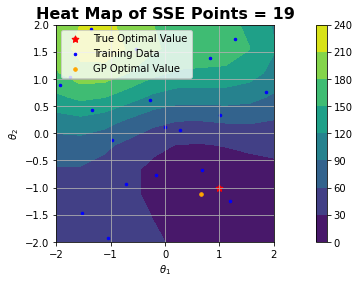

In [11]:
title = "SSE"
y_plotter(theta_mesh, sse, Theta_True, Theta_Opt_GP, train_T,title,plot_train=True)

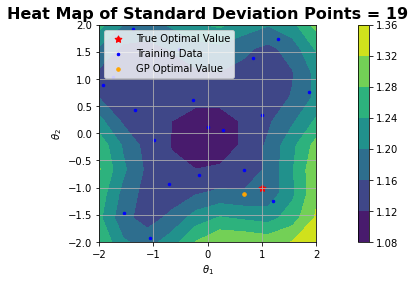

In [12]:
stdev_plotter(theta_mesh, stdev,Theta_True, Theta_Opt_GP,train_T,plot_train=True)

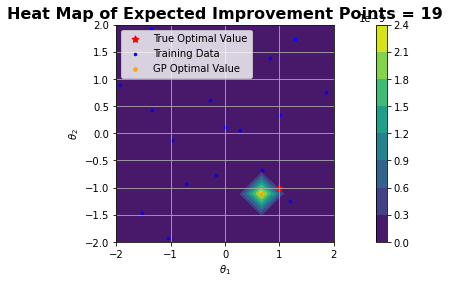

In [13]:
ei_plotter(theta_mesh, ei, Theta_True, Theta_Opt_GP,train_T,plot_train=True)